
## <center>** Anime recommendations and score prediction **


Welcome to this project where we will follow the data mining process to end up by creating some machine learning algorithms.

`in this project we will follow the following steps:`

* Create a web scraping script which collects data about animes and build our dataset.
* Understand the dataset using Data description and visualization techniques.
* Clean the dataset and apply dimensionality reduction techniques to make it ready to be trained.
* Apply some ML algorithms to create a recommendation system and a score predictor.

----------------------------
----------------------------

### <center> `Anime Scraping` 

In this part we will run a web scraping script using the libraries request and BeautifulSoop to collect some information about a list of animes based on a very famous site web in this domain called my anime list (we choose this site web because it is used by people in the whole world so information collected will be more reliable and our algorithms will give better results). 

In [385]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [386]:
df_final = pd.DataFrame(columns=['rank','score','title','type','genres','episodes','producers','trailer','image','description'])
for h in range(0,4150,50):
    req = requests.get('https://myanimelist.net/topanime.php',params={'limit':h})
    soup = BeautifulSoup(req.text, 'html.parser')
    animes = soup.find_all('tr')[1:]
    df = pd.DataFrame(columns=['rank','score','title','type','genres','episodes','producers','trailer','image','description'])
    for anime in animes :
        rank = int(anime.find_all('td')[0].find('span').text)
        score = float(anime.find_all('td')[2].find('span').text)
        link = anime.find_all('td')[1].find('a').get('href')
        re = requests.get(link)
        if (re.status_code == 200) :
            s = BeautifulSoup(re.text, 'html.parser')
            try:
                title = s.find('p',{'class':'title-english title-inherit'}).text
            except:
                try: title = s.find('p',{'class':'title-english title-inherit'}).text
                except: 
                    try : title = s.find('h1').text
                    except: title= None
            finally :
                try: trailer_link = s.find('div',{"class":"video-promotion"}).find('a').get('href')
                except : trailer_link = None
                try: image = s.find('tr').find('img').get('data-src')
                except: image = None
                try: description = s.find('p',{"itemprop":"description"}).text
                except: description = None
                a = s.find('td',{'style':'border-width: 0 1px 0 0;'}).find_all('div',{'class':'spaceit_pad'})
                for i in a[2:]:
                    t = i.find('span').text
                    if (t =='Type:'):
                        try : type = i.find('a').text
                        except :
                            try: type = i.text.split()[1]
                            except : type = None
                    elif (t == 'Episodes:'):
                        try: episodes = i.text.split()[1]
                        except: episodes = None
                    elif (t == 'Producers:'):
                        try: producers = [x.text for x in i.find_all("a")]
                        except: producers = None
                    elif (t == 'Genres:'):
                        try: genres = [x.text for x in i.find_all("a")]
                        except: genres = None
                        break
                df.loc[len(df)] = [rank,score,title,type,genres,episodes,producers,trailer_link,image,description]
    print(h)
    df_final=pd.concat([df_final,df],axis=0).reset_index(drop=True)
df_final.to_csv("animes.csv")

## **The Dataset**

By the end of this step we have a dataset which contains data on anime listings. It contains the following columns:

- `rank`: This a unique attribute for each anime which identify the rank of the list in listing
- `score`: A score between 0 and 9 which is calculated according to people feedback in the whole word
- `title`: Or the name of the anime
- `type`: type of anime either TV, movie ... 
- `genres`: genres of anime (sport, comedy, drama, action ...)
- `episodes`: number of episodes of anime
- `producers`: Companies which contribute to the production of the anime
- `trailer`: A link to the trailer video of the anime
- `image`: A link to the poster of the anime
- `description`: a paragraph which describes the anime

----------------------------
----------------------------

### <center> `Data Cleaning` 

In this part we will try to understand our data using some visualization plots and statistical metrics

In [387]:
df = pd.read_csv('animes.csv', index_col = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4150 entries, 0 to 4149
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rank         4150 non-null   int64  
 1   score        4150 non-null   float64
 2   title        4150 non-null   object 
 3   type         4150 non-null   object 
 4   genres       4150 non-null   object 
 5   episodes     4150 non-null   object 
 6   producers    4150 non-null   object 
 7   trailer      2274 non-null   object 
 8   image        4150 non-null   object 
 9   description  4150 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 356.6+ KB


In [388]:
# first we need to drop some columns
anime = df.drop(['description','image','trailer'], axis=1)
anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4150 entries, 0 to 4149
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   rank       4150 non-null   int64  
 1   score      4150 non-null   float64
 2   title      4150 non-null   object 
 3   type       4150 non-null   object 
 4   genres     4150 non-null   object 
 5   episodes   4150 non-null   object 
 6   producers  4150 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 259.4+ KB


In [389]:
anime.head()

,rank,score,title,type,genres,episodes,producers
0,1,9.11,Bleach: Thousand-Year Blood War,TV,"['Action', 'Adventure', 'Fantasy']",13,"['TV Tokyo', 'Aniplex', 'Dentsu', 'Shueisha']"
1,2,9.11,Fullmetal Alchemist: Brotherhood,TV,"['Action', 'Adventure', 'Drama', 'Fantasy']",64,"['Aniplex', 'Square Enix', 'Mainichi Broadcast..."
2,3,9.08,Steins;Gate,TV,"['Drama', 'Sci-Fi', 'Suspense']",24,"['Frontier Works', 'Media Factory', 'Movic', '..."
3,4,9.07,Gintama Season 4,TV,"['Action', 'Comedy', 'Sci-Fi']",51,"['TV Tokyo', 'Aniplex', 'Dentsu']"
4,5,9.07,Kaguya-sama: Love is War - Ultra Romantic,TV,"['Comedy', 'Romance']",13,"['Aniplex', 'Mainichi Broadcasting System', 'M..."


In [390]:
# find duplicates
anime.duplicated().any()

False

In [391]:
# find if the rank column has some duplicates because this variable must be unique for each anime 
anime.duplicated(subset='rank').any()

False

## **Our to do list:**

_type column:_

- **`Task 1`**: transform categorical data into numeric data but we have to use one-hot encoding techniques because the recommendation algo calculates distances
<br>

_episodes column:_

- **`Task 2`**: there are some animes with unknown number of episodes so in most cases these anime are still not finished so we need to estimate the final number of episodes because this feature is very important in our study (for example a person who like an anime of 24 episodes it is logical to recommend him an anime with closer number of episodes also the number of episodes influences a lot the score for example most people prefer short stories)
- **`Task 3`**: Convert data to int 
<br>

_genres&producers column:_

- **`Task 4`**: firstly values in these columns are a string which contain a list of strings so we need to convert it to a list of strings and then find uniques values (for producers and genres) then use one hot encoder to convert them to numeric data
<br>

_Dealing with missing data and duplicates:_

- fortunately we don't have messing values (except Unknown values in the episodes column) also we don't have duplicates especially we don't have duplicates in the rank column which need to be unique. 



#### 1- episodes type column 

In [392]:
anime['episodes'].unique()

array(['13', '64', '24', '51', '10', '1', '148', '110', '12', '22', '201',
       '25', '7', '14', '74', '11', '26', '16', '75', '47', '4', '43',
       'Unknown', '27', '37', '39', '23', '101', '99', '2', '15', '112',
       '6', '8', '120', '62', '50', '20', '40', '33', '94', '79', '3',
       '52', '500', '17', '77', '78', '96', '70', '291', '170', '203',
       '38', '21', '102', '30', '63', '28', '45', '5', '103', '220', '9',
       '153', '109', '34', '69', '145', '36', '366', '60', '167', '178',
       '49', '35', '113', '155', '1787', '54', '373', '161', '100', '114',
       '19', '46', '97', '195', '104', '358', '42', '31', '61', '127',
       '48', '56', '142', '73', '136', '175', '115', '150', '53', '147',
       '29', '140', '124', '224', '76', '44', '18', '154', '131', '58',
       '130', '72', '87', '276', '67', '93', '330', '128', '384', '105',
       '172', '86', '137', '41', '92', '191', '91', '180', '65', '243',
       '182', '59', '66', '192', '55', '193', '280', '26

In [393]:
# the number of animes with unknown number of episodes
anime['episodes'].value_counts()['Unknown']

21

In [ ]:
# now we will find the most frequent number of episodes of each type because the number of episodes is Highly related
# to the type (for example the mode for Movies is 1 episode and it's logical but if we try to fill all unknown number
# of episodes without caring of types we will choose 1 episode for all of them because in our dataset we have a lot of 
# movies however this will lead to wrong estimations)

epis_mode_per_type = anime.groupby('type')['episodes'].apply(lambda x:x.mode())
epis_mode_per_type

type      
Movie    0     1
Music    0     1
ONA      0    12
OVA      0     1
Special  0     1
TV       0    12
Name: episodes, dtype: object

In [394]:
anime.loc[anime['rank']==56, 'episodes'] = '1000' # this is a special anime (one piece) with a TV type but it has a special
# number of episodes and the reason why we choose to fix this number is that it is a very famous anime so it is important to 
# have real informations about it (for example if we try to recommend animes to a person who like long ones a reliable 
# result must include one piece)

anime.loc[anime['episodes']=='Unknown', 'episodes'] = [epis_mode_per_type[i].values[0] for i in anime.loc[anime['episodes']=='Unknown', 'type']]

anime['episodes']=anime['episodes'].astype('int')
anime['episodes'].unique()

array([  13,   64,   24,   51,   10,    1,  148,  110,   12,   22,  201,
         25,    7,   14,   74,   11,   26,   16,   75,   47,    4,   43,
       1000,   27,   37,   39,   23,  101,   99,    2,   15,  112,    6,
          8,  120,   62,   50,   20,   40,   33,   94,   79,    3,   52,
        500,   17,   77,   78,   96,   70,  291,  170,  203,   38,   21,
        102,   30,   63,   28,   45,    5,  103,  220,    9,  153,  109,
         34,   69,  145,   36,  366,   60,  167,  178,   49,   35,  113,
        155, 1787,   54,  373,  161,  100,  114,   19,   46,   97,  195,
        104,  358,   42,   31,   61,  127,   48,   56,  142,   73,  136,
        175,  115,  150,   53,  147,   29,  140,  124,  224,   76,   44,
         18,  154,  131,   58,  130,   72,   87,  276,   67,   93,  330,
        128,  384,  105,  172,   86,  137,   41,   92,  191,   91,  180,
         65,  243,  182,   59,   66,  192,   55,  193,  280,  260,  296])

#### 2- type column 

In [395]:
anime['type'].unique()
# our task with this column is to transform it to nemuric data

array(['TV', 'Movie', 'OVA', 'ONA', 'Special', 'Music'], dtype=object)

In [396]:
# Create a new dataframe with one-hot encoded type
types_df = pd.get_dummies(anime['type'])
# Concatenate the original dataframe with the one-hot encoded type dataframe
anime = pd.concat([anime, types_df], axis=1)
# Drop the original 'type' column
anime.drop(['type'], axis=1, inplace=True)
# Print the updated dataframe
anime

,rank,score,title,genres,episodes,producers,Movie,Music,ONA,OVA,Special,TV
0,1,9.11,Bleach: Thousand-Year Blood War,"['Action', 'Adventure', 'Fantasy']",13,"['TV Tokyo', 'Aniplex', 'Dentsu', 'Shueisha']",0,0,0,0,0,1
1,2,9.11,Fullmetal Alchemist: Brotherhood,"['Action', 'Adventure', 'Drama', 'Fantasy']",64,"['Aniplex', 'Square Enix', 'Mainichi Broadcast...",0,0,0,0,0,1
2,3,9.08,Steins;Gate,"['Drama', 'Sci-Fi', 'Suspense']",24,"['Frontier Works', 'Media Factory', 'Movic', '...",0,0,0,0,0,1
3,4,9.07,Gintama Season 4,"['Action', 'Comedy', 'Sci-Fi']",51,"['TV Tokyo', 'Aniplex', 'Dentsu']",0,0,0,0,0,1
4,5,9.07,Kaguya-sama: Love is War - Ultra Romantic,"['Comedy', 'Romance']",13,"['Aniplex', 'Mainichi Broadcasting System', 'M...",0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4145,4146,6.98,Gunslinger Girl: Il Teatrino OVA,"['Action', 'Drama', 'Sci-Fi']",2,['Marvelous'],0,0,0,1,0,0
4146,4147,6.98,Jewelpet Twinkle☆: Hohoemi no Niji ni Dokki☆Doki!,"['Action', 'Drama', 'Sci-Fi']",1,"['TV Tokyo', 'Studio Jack']",0,0,0,0,1,0
4147,4148,6.98,The Jungle Book,"['Adventure', 'Drama']",52,['add some'],0,0,0,0,0,1
4148,4149,6.98,Kagejitsu!,"['Comedy', 'Fantasy']",12,"['AT-X', 'BS NTV', 'Kadokawa', 'NewGin', 'Aimi...",0,0,1,0,0,0


#### 3- producers columns 

In [397]:
print(anime['producers'].unique()[0]) 
print(type(anime['producers'].unique()[0])) # we have str type not a list of strings
print(len(anime['producers'].unique()))
print("[]" in anime['producers'].unique()) # we check if there are any null values

['TV Tokyo', 'Aniplex', 'Dentsu', 'Shueisha']
<class 'str'>
1973
False


In [398]:
# firstly we need to replace each value (type string) to a list of strings 
anime['producers'] = anime['producers'].apply(lambda x: re.sub(r"\[|\]|\'| ","",x).split(','))
print(anime['producers'][0])
print(type(anime['producers'][0]))

['TVTokyo', 'Aniplex', 'Dentsu', 'Shueisha']
<class 'list'>


In [399]:
# now we have to find the unique producers because for one anime we can have many producers and if we try one-hot encoder
# directly we will have non-significant results because our goal is to find if a producer contribute to the production of 
# an anime but if we use one-hot encoder directly we will check for a list of producers not a single producer 
from collections import Counter
s=[]
# here we create a list of all producers (with duplications)
for i in anime['producers'].values:
    s+=i
# then we use the Counter to calculate the occurrence of each producer then we sort the results by occurrence
# (most frequent first) using most_common() method
print(Counter(s).most_common()[:5])
print("the number of unique producers : ",len(Counter(s).most_common())) 
# we have 758 different producers but a lot of them are not famous (they work in few animes) so we need to filter them out
print("the number of producers which work in more than 50 animes :",len([i for i in Counter(s).most_common() if i[1]>=50]))

[('addsome', 1021), ('Aniplex', 370), ('TVTokyo', 278), ('Dentsu', 255), ('Movic', 239)]
the number of unique producers :  758
the number of producers which work in more than 50 animes : 54


In [400]:
# now we will create a new column for each producer which work in more than 50 animes 
for producer in [i[0] for i in Counter(s).most_common() if i[1]>=50]:
    anime[producer] = anime['producers'].apply(lambda x:1 if (producer in x) else 0)
anime[['producers','Aniplex','Dentsu']].head()

,producers,Aniplex,Dentsu
0,"[TVTokyo, Aniplex, Dentsu, Shueisha]",1,1
1,"[Aniplex, SquareEnix, MainichiBroadcastingSyst...",1,0
2,"[FrontierWorks, MediaFactory, Movic, AT-X, Kad...",0,0
3,"[TVTokyo, Aniplex, Dentsu]",1,1
4,"[Aniplex, MainichiBroadcastingSystem, MagicCap...",1,0


In [401]:
anime.drop(['producers'], axis=1, inplace=True)

#### 4- genres columns   `(Same work we did on the previous column)`

In [402]:
print(anime['genres'].unique()[0])
print(type(anime['genres'].unique()[0])) # we have str type not a list of strings
print(len(anime['genres'].unique()))
print("[]" in anime['genres'].unique()) # we check if there are any null values

['Action', 'Adventure', 'Fantasy']
<class 'str'>
545
False


In [403]:
# firstly we need to replace each value (type string) to a list of strings 
anime['genres'] = anime['genres'].apply(lambda x: re.sub(r"\[|\]|\'| ","",x).split(','))
print(anime['genres'][0])
print(type(anime['genres'][0]))

['Action', 'Adventure', 'Fantasy']
<class 'list'>


In [404]:
from collections import Counter
g=[]
# here we create a list of all genres (with duplications)
for i in anime['genres'].values:
    g+=i
# then we use the Counter to calculate the occurrence of each genre then we sort the results by occurrence
# (most frequent first) using most_common() method
print(Counter(g).most_common()[:5])
print("the number of unique genres : ",len(Counter(g).most_common())) 
# we have only 19 different genres so we don't need to filter them out

[('Action', 1857), ('Comedy', 1806), ('Fantasy', 1345), ('Adventure', 1249), ('Drama', 1223)]
the number of unique genres :  19


In [405]:
# now we will create a new column for each producer which work in more than 50 animes 
for genre in [i[0] for i in Counter(g).most_common()]:
    anime[genre] = anime['genres'].apply(lambda x:1 if (genre in x) else 0)
anime[['genres','Action','Adventure','Drama']].head()

,genres,Action,Adventure,Drama
0,"[Action, Adventure, Fantasy]",1,1,0
1,"[Action, Adventure, Drama, Fantasy]",1,1,1
2,"[Drama, Sci-Fi, Suspense]",0,0,1
3,"[Action, Comedy, Sci-Fi]",1,0,0
4,"[Comedy, Romance]",0,0,0


In [406]:
anime.drop(['genres'], axis=1, inplace=True)
print(anime.shape)
anime.columns

(4150, 83)


Index(['rank', 'score', 'title', 'episodes', 'Movie', 'Music', 'ONA', 'OVA',
       'Special', 'TV', 'addsome', 'Aniplex', 'TVTokyo', 'Dentsu', 'Movic',
       'Lantis', 'Kodansha', 'BandaiVisual', 'Shueisha', 'AT-X', 'FujiTV',
       'PonyCanyon', 'MainichiBroadcastingSystem', 'KlockWorx', 'Sotsu',
       'Kadokawa', 'KadokawaShoten', 'TBS', 'TOHOanimation',
       'StarchildRecords', 'flyingDOG', 'Shochiku', 'TokyoMX', 'FrontierWorks',
       'NihonAdSystems', 'Shogakukan-ShueishaProductions', 'DAXProduction',
       'VAP', 'SonyMusicEntertainment', 'SquareEnix', 'MediaFactory',
       'MagicCapsule', 'TVAsahi', 'NipponTelevisionNetwork', 'Showgate',
       'WarnerBros.Japan', 'BS11', 'GeneonUniversalEntertainment', 'NHK',
       'Toho', 'Genco', 'TencentPenguinPictures', 'HakuhodoDYMusic&Pictures',
       'GoodSmileCompany', 'bilibili', 'KingRecords', 'Shogakukan',
       'AvexPictures', 'TVTokyoMusic', 'ProductionI.G', 'KadokawaMediaHouse',
       'HalfH.PStudio', 'AsmikAce', 'Bush

---
---
## <center> `Data description and visualization`

In [407]:
anime.drop(['title','rank'], axis=1).describe()
# thankfully we don't have range problems (for example the max of scores < 10)

,score,episodes,Movie,Music,ONA,OVA,Special,TV,addsome,Aniplex,...,SliceofLife,Ecchi,AwardWinning,Horror,Suspense,Sports,Gourmet,BoysLove,GirlsLove,AvantGarde
count,4150.000000,4150.000000,4150.000000,4150.000000,4150.000000,4150.000000,4150.000000,4150.000000,4150.000000,4150.000000,...,4150.000000,4150.000000,4150.000000,4150.000000,4150.000000,4150.000000,4150.000000,4150.000000,4150.000000,4150.000000
mean,7.514067,16.122169,0.198795,0.024819,0.068916,0.114940,0.108916,0.483614,0.246024,0.089157,...,0.090602,0.055663,0.041928,0.036627,0.027470,0.024096,0.014458,0.012289,0.011807,0.006988
std,0.415456,42.053023,0.399142,0.155593,0.253341,0.318988,0.311571,0.499792,0.430745,0.285004,...,0.287077,0.229297,0.200448,0.187866,0.163468,0.153367,0.119383,0.110186,0.108031,0.083311
min,6.980000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.200000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.410000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.740000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.110000,1787.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:xlabel='score', ylabel='Count'>

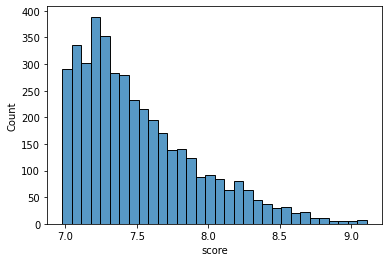

In [408]:
# the distribution of scores
sns.histplot(data=anime, x='score')

we can conclude that there are a few animes with high scores(>8.5) and the majority of scores are between 7 and 7.5

<AxesSubplot:ylabel='episodes'>

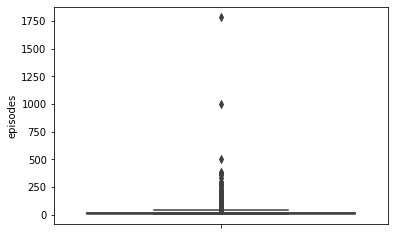

In [409]:
# the distribution of episodes
sns.boxplot(data=anime, y='episodes')

we can see that the majority of animes have a number of episodes < 100 but we have some outliers

<AxesSubplot:ylabel='episodes'>

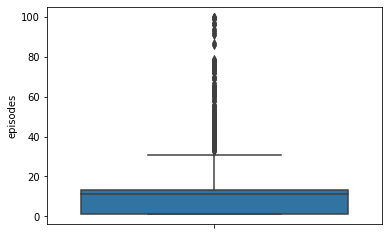

In [410]:
sns.boxplot(data=anime[anime['episodes']<=100], y='episodes')

([<matplotlib.patches.Wedge at 0x1d5f00a6100>,
 [Text(-0.7692329713304488, 0.7863082320681434, 'epis <= 15'),
  Text(0.45702542945947294, -1.0005637195238415, '30 < epis <= 100'),
  Text(1.013294965123107, -0.42805760553477085, '15 < epis <= 30'),
  Text(1.0984115352186992, -0.05909398699106775, 'epis > 100')])

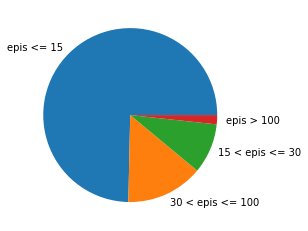

In [411]:
# also we can use a pie chart
anime['filter']=anime['episodes'].apply(lambda x : "epis <= 15" if x<=15 \
                    else "15 < epis <= 30" if (x>15)and(x<=30) \
                    else "30 < epis <= 100" if (x>30)and(x<=100) \
                    else "epis > 100")
plt.pie(anime['filter'].value_counts()/len(anime['filter']) * 100, labels = anime['filter'].unique())

now we can specify more and say that the majority of animes have less than 15 episodes

(array([0, 1, 2, 3]),
 [Text(0, 0, 'epis <= 15'),
  Text(1, 0, '30 < epis <= 100'),
  Text(2, 0, '15 < epis <= 30'),
  Text(3, 0, 'epis > 100')])

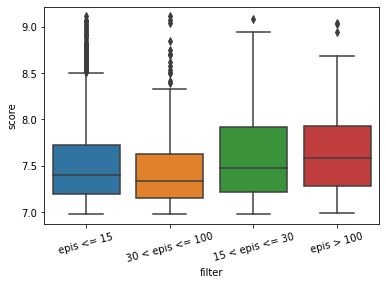

In [412]:
# how does the number of episodes influences the score
sns.boxplot(data= anime, x="filter" , y='score')
plt.xticks(rotation=15)

se we can see that for all categories scores are close and long animes have a higher score compared to other categories but we have outliers (for example there are some short animes that have a higher score)

<AxesSubplot:xlabel='type', ylabel='count'>

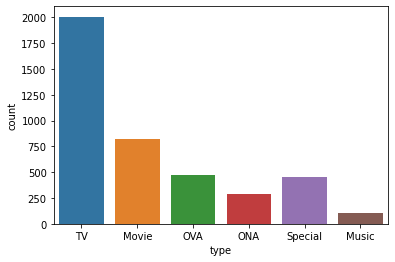

In [413]:
# now let's see the distribution of types 
sns.countplot(data=df, x='type')

(6.0, 9.0)

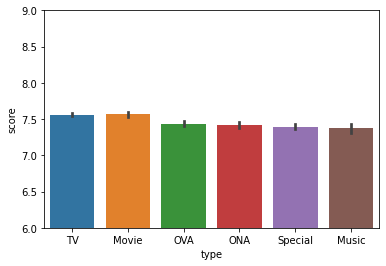

In [414]:
# how does the type of animes influences the score
ax=sns.barplot(x='type',y='score',data=df)
ax.set_ylim([6,9])

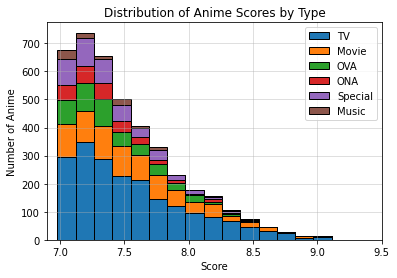

In [415]:
# how does the type of animes influences the score

# Create a list of scores for each anime type
scores_by_type = []
type_labels = []

for anime_type in df['type'].unique():
    scores_by_type.append(df.score[df.type == anime_type].values)
    type_labels.append(anime_type)

# Create the histogram
n_bins = 15
fig, ax = plt.subplots()
_, _, patches = ax.hist(scores_by_type, bins=n_bins, stacked=True, rwidth=1, label=type_labels, edgecolor='black')
ax.set_xlabel('Score')
ax.set_ylabel('Number of Anime')
ax.set_title('Distribution of Anime Scores by Type')
ax.set_xlim([6.9, 9.5])
ax.grid(alpha=0.5)

# Add outlines to bins
for patch in patches:
    for rect in patch:
        rect.set_edgecolor('black')

ax.legend()
plt.show()


we can see that animes which have high scores (>8.5) are either TV or Movies so we can say that people like more TVs and movies

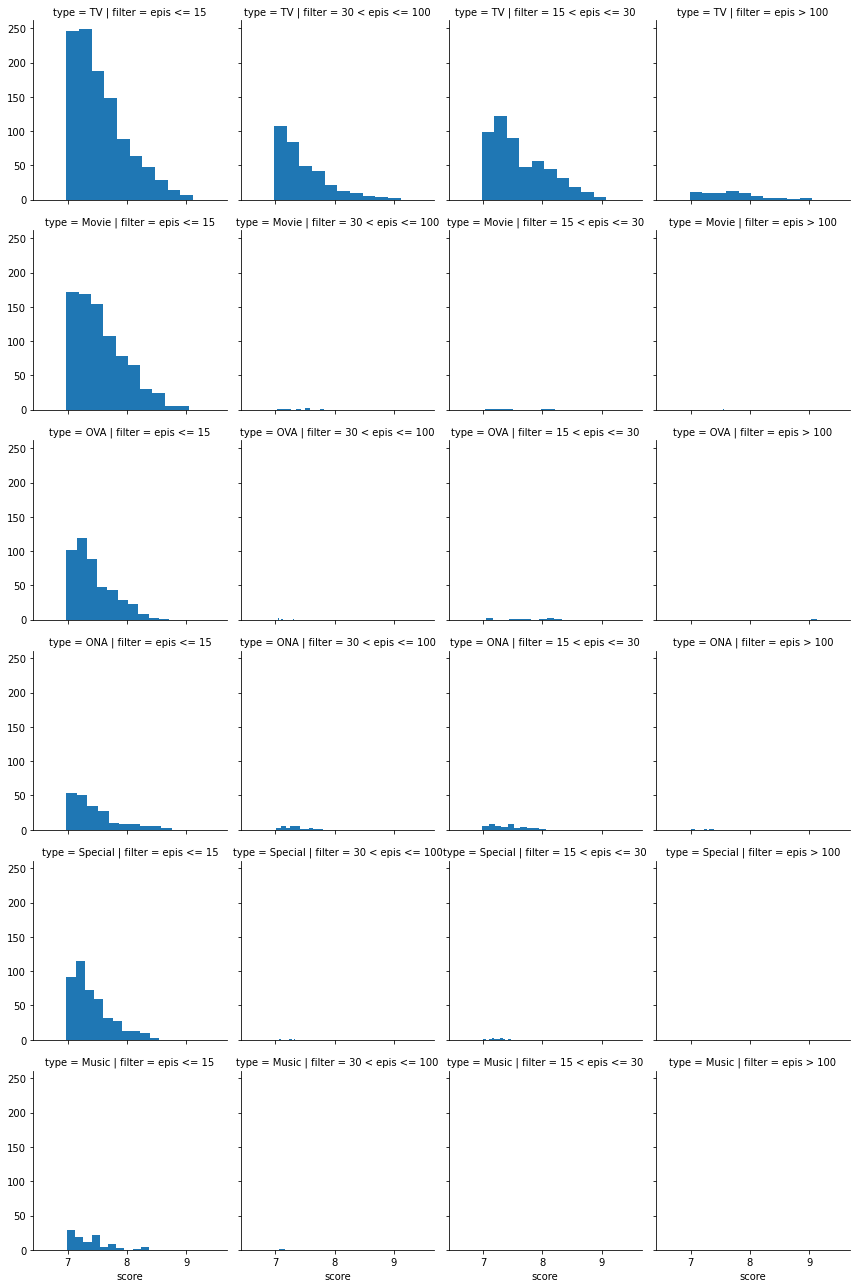

In [416]:
df['filter']=anime['filter']
g = sns.FacetGrid(df, row='type', col='filter') # we created grid to populate our figure in it
g = g.map(plt.hist,'score')
anime.drop(['filter'], axis=1, inplace=True)

this plot show that people like short animes espicialy of type TV

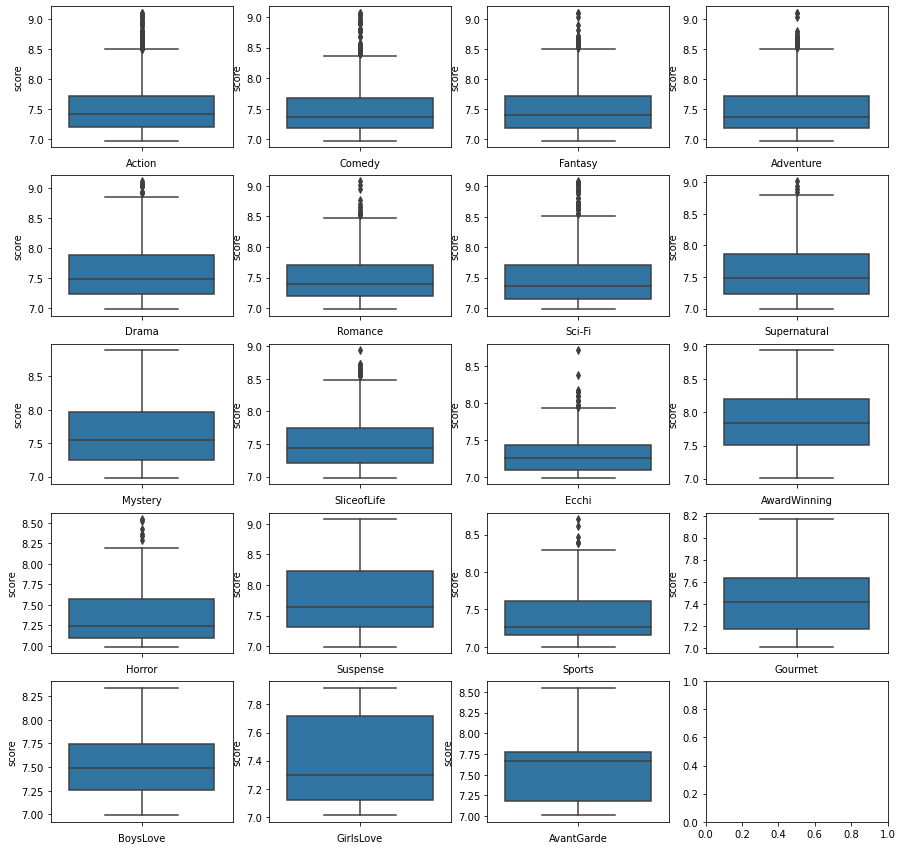

In [417]:
# how can the genres impact the score of animes
genres = anime.columns[-19:]

f, axes = plt.subplots(5,4,figsize=(15,15))
i,j=0,0
for genre in (genres):
    ax = sns.boxplot(data=anime[anime[genre]==1],x=genre,y='score',ax=axes[i,j])
    ax.set(xticklabels=[])
    j+=1
    if (j==4):
        j=0
        i+=1

<AxesSubplot:>

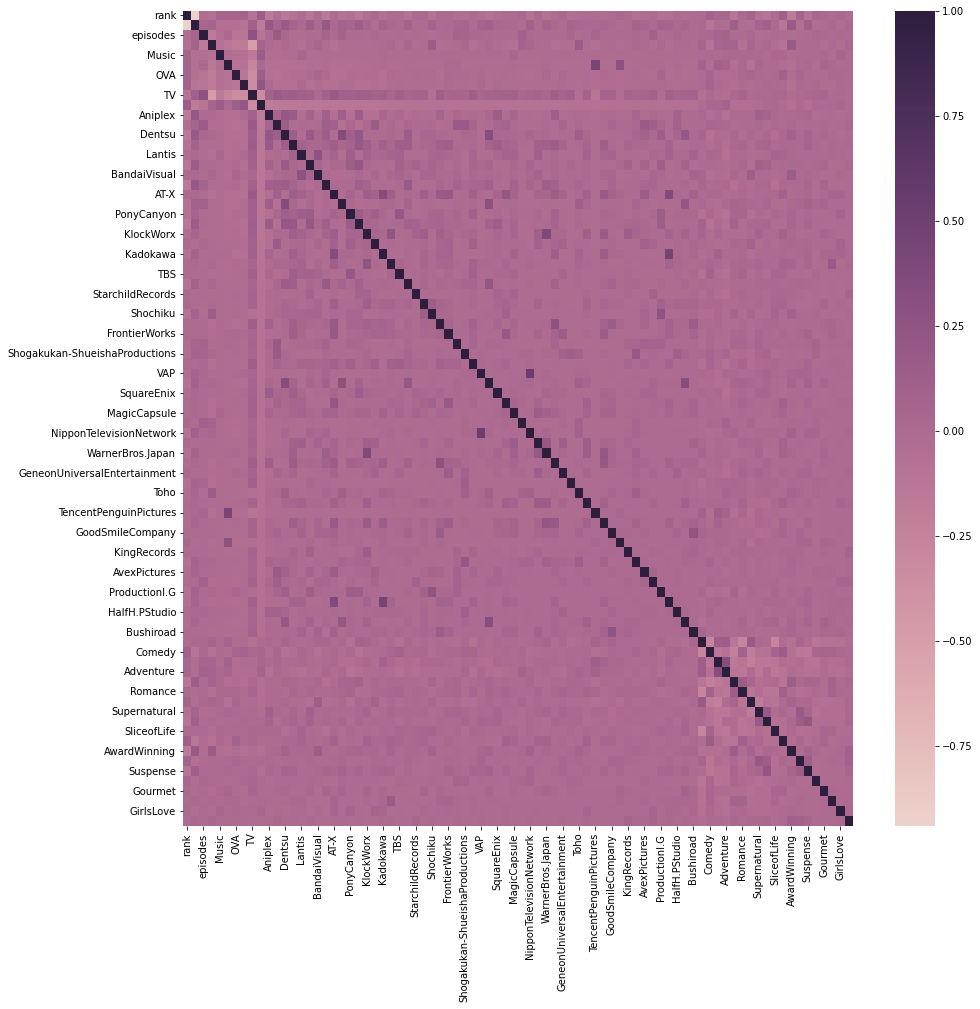

In [418]:
# correlation and heatmap
plt.figure(figsize=(15,15))
sns.heatmap(anime.corr(),cmap=sns.cubehelix_palette(as_cmap=True))

we can see that there is no correlation (relationship) between these variables

---
---
## <center> `Data Reduction`

### 1- Feature Selection

In [419]:
anime_1 = anime.drop(['title','rank'], axis=1)
anime_1.shape

(4150, 81)

In [420]:
from sklearn.preprocessing import StandardScaler

# first we will split the dataset into target and features
X = anime_1.drop("score",axis=1)
y = anime_1["score"]

# Standardize the selected features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)# now our dataset contain only nemuric values 

# now we will apply a filter method (f-value) to select top 10 features 
from sklearn.feature_selection import SelectKBest, f_classif
kbest = SelectKBest(f_classif, k=56)
X_kbest = kbest.fit(data_scaled,y)

# Get the selected feature names and scores
selected_feature = pd.DataFrame(list(zip(X.columns, X_kbest.scores_)), columns=['Feature', 'Score'])
selected_feature = selected_feature.sort_values(by='Score', ascending=False).head(56)
print(selected_feature.Score.sum())
selected_feature

90.23671667389054


,Feature,Score
72,AwardWinning,3.385236
15,Shueisha,3.281444
74,Suspense,2.702081
8,Aniplex,2.619202
10,Dentsu,2.363983
42,WarnerBros.Japan,2.290983
13,Kodansha,2.239134
19,MainichiBroadcastingSystem,2.164880
56,ProductionI.G,2.153168
65,Drama,2.136204


In [421]:
anime_fs = anime_1[selected_feature.Feature.unique()]
anime_fs.shape

(4150, 56)

### 2- PCA

In [422]:
from sklearn.decomposition import PCA
variance_totale = []

for i in range(81):
    pca = PCA(i)
    reduced_data = pca.fit_transform(data_scaled)
    print("\nShape : {}".format(reduced_data.shape))
    s = "{:.2f}%  "*(i)
    print("Pourcentages de variance expliquée :"+s.format(*pca.explained_variance_ratio_*100))
    variance = pca.explained_variance_ratio_.sum()*100
    variance_totale.append(variance)
    print("Variance totale expliquée : {:.2f}%".format(variance))


Shape : (4150, 0)
Pourcentages de variance expliquée :
Variance totale expliquée : 0.00%

Shape : (4150, 1)
Pourcentages de variance expliquée :3.89%  
Variance totale expliquée : 3.89%

Shape : (4150, 2)
Pourcentages de variance expliquée :3.89%  3.00%  
Variance totale expliquée : 6.89%

Shape : (4150, 3)
Pourcentages de variance expliquée :3.89%  3.00%  2.61%  
Variance totale expliquée : 9.51%

Shape : (4150, 4)
Pourcentages de variance expliquée :3.89%  3.00%  2.61%  2.46%  
Variance totale expliquée : 11.97%

Shape : (4150, 5)
Pourcentages de variance expliquée :3.89%  3.00%  2.62%  2.46%  2.28%  
Variance totale expliquée : 14.24%

Shape : (4150, 6)
Pourcentages de variance expliquée :3.89%  3.00%  2.61%  2.46%  2.27%  2.19%  
Variance totale expliquée : 16.43%

Shape : (4150, 7)
Pourcentages de variance expliquée :3.89%  3.00%  2.62%  2.46%  2.28%  2.19%  2.16%  
Variance totale expliquée : 18.60%

Shape : (4150, 8)
Pourcentages de variance expliquée :3.89%  3.00%  2.61%  2.45

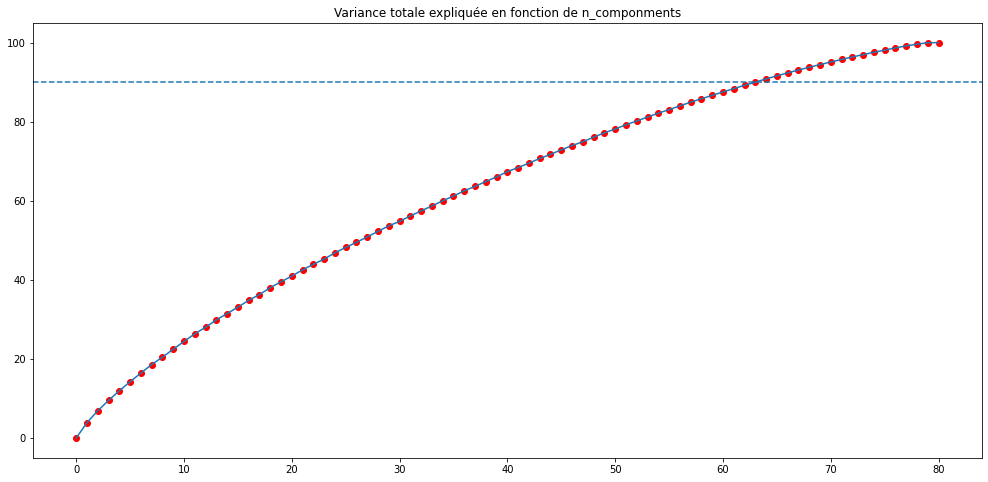

In [423]:
# visualizing the variation of explained variance according to the number of components
plt.figure(figsize=(17,8))
plt.plot(variance_totale)
plt.scatter(np.arange(81), variance_totale, color='red')
plt.axhline(90, linestyle='--')
plt.title("Variance totale expliquée en fonction de n_componments")
plt.show()

In [424]:
pca = PCA(n_components=65)
X_pca = pca.fit_transform(data_scaled)
anime_pca = pd.DataFrame(data = X_pca, columns = [f'PC{i}' for i in range(1,66)])
print("Variance totale expliquée : {:.2f}%".format(pca.explained_variance_ratio_.sum()*100))
print('shape : ',anime_pca.shape)

Variance totale expliquée : 91.61%
shape :  (4150, 65)


`As we can see either from the pca or feature selection, all columns have close explained variances so we can't reduce the number of variables a lot because we should keep a reasonable total of explained variances (>=90%)`

---
---
### <center> `Predicting the score using regression algorithms`

in this part we will try to build a regression model to predict the score of a given anime, but as we notice in the previous section there are few differences between the original data (anime_1), data after features selection (anime_fs) and data after pca (anime_pca) ==> so we will try all of these data and many of famous regression models to choose finally the best model

In [425]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [426]:
result_df = pd.DataFrame(index=['LinearRegression','Ridge','SVR_linear','SVR_rbf','SVR_poly','RandomForestRegressor'])

In [431]:
reg_x=anime_fs
reg_y=anime_1.score
reg_x.shape, reg_y.shape

((4150, 56), (4150,))

In [435]:
reg_x_train, reg_x_test, reg_y_train, reg_y_test = train_test_split(reg_x, reg_y, test_size = 0.25, random_state=0)
reg_x_train.shape , reg_x_test.shape, reg_y_train.shape, reg_y_test.shape

((3112, 80), (1038, 80), (3112,), (1038,))

In [429]:
mdl = LinearRegression()
mdl.fit(reg_x_train, reg_y_train)
reg_pred = mdl.predict(reg_x_test)
print("MAE : ", mean_absolute_error(reg_y_test, reg_pred))
print("MSE : ", mean_squared_error(reg_y_test, reg_pred))
print("R^2 : ", r2_score(reg_y_test, reg_pred))

MAE :  0.3071901723797979
MSE :  0.1468153787056852
R^2 :  0.1980978160008955


`we can observe clearly that our algorithm is not good so we can make a first proposition that the relationship between the dependent variable and independent variables is non linear` 

In [436]:
regression_models = {'LinearRegression':LinearRegression(),
                     'Ridge':Ridge(),
                     'SVR_linear':SVR(kernel='linear'),
                     'SVR_rbf':SVR(kernel='rbf'),
                     'SVR_poly':SVR(kernel='poly'),
                     'RandomForestRegressor':RandomForestRegressor()}
MAE, MSE, R_squared = [],[],[]
for model in regression_models.values():
    model.fit(reg_x_train, reg_y_train)
    reg_pred = model.predict(reg_x_test)
    MAE.append(mean_absolute_error(reg_y_test, reg_pred))
    MSE.append(mean_squared_error(reg_y_test, reg_pred))
    R_squared.append(r2_score(reg_y_test, reg_pred))
result_df ["MAE_original"]= MAE
result_df ["MSE_original"]= MSE
result_df ["r2_original"]= R_squared

result_df

,MAE_pca,MSE_pca,r2_pca,MAE_fs,MSE_fs,r2_fs,MAE_original,MSE_original,r2_original
LinearRegression,0.307190,0.146815,0.198098,0.308650,0.146861,0.197849,0.308614,0.147455,0.194602
Ridge,0.307192,0.146815,0.198099,0.308574,0.146780,0.198291,0.308515,0.147327,0.195305
SVR_linear,0.302381,0.153159,0.163447,0.303094,0.152785,0.165493,0.305345,0.155194,0.152336
SVR_rbf,0.285036,0.135337,0.260794,0.312592,0.168527,0.079507,0.312294,0.168404,0.080182
SVR_poly,0.307957,0.288354,-0.574981,0.497861,28.956603,-157.160290,0.497154,28.776421,-156.176140
RandomForestRegressor,0.293037,0.135058,0.262317,0.290021,0.138728,0.242274,0.283624,0.132726,0.275054


---
---
### <center> `anime recommendations algorithm`

In [442]:
from sklearn.metrics.pairwise import cosine_similarity

# calculate cosine similarity
cosine_sim = cosine_similarity(anime_pca, anime_pca)

In [458]:
from sklearn.metrics.pairwise import cosine_similarity

# calculate cosine similarity
cosine_sim = cosine_similarity(anime_1, anime_1)

# function to get recommendations
def anime_recommendations(title, cosine_sim=cosine_sim, anime_df=anime):
    # get index of the anime title
    idx = anime_df[anime_df['title'] == title].index[0]
    
    # get the cosine similarity scores for all anime
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # sort the anime based on the cosine similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # get the top 5 most similar anime
    sim_scores = sim_scores[1:6]
    
    # get the anime indices
    anime_indices = [i[0] for i in sim_scores]
    
    # return the top 10 most similar anime
    return anime_df['title'].iloc[anime_indices]


In [459]:
anime_recommendations('One Piece')

958                                             Doraemon
286                                     Naruto Shippuden
2460                            The God of War Dominates
978     Kochira Katsushikaku Kameari Kouenmae Hashutsujo
1163                                           Sgt. Frog
Name: title, dtype: object

In [462]:
anime_recommendations('Haikyu!! 3rd Season')

97                        Haikyu!! TO THE TOP 2nd-cour
498                       Black Butler: Book of Circus
391                               Moriarty the Patriot
701                                   My Hero Academia
1634    The Millionaire Detective – Balance: UNLIMITED
Name: title, dtype: object